Las cuatro redes de proteínas de levadura que
disponemos: Y2H, AP-MS, LIT y Lit-Reguly. Las dos últimas son redes construidas a partir de
interacciones reportadas en la literatura. 

In [1]:
#librerias a utilizar
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as scipy
import random

In [2]:
#Para abrir archivos
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    if os.path.basename(nombre_archivo) == 'yeast_LIT_Reguly.txt':
        data = data[1:]
        enlaces = []
        for linea in data:
            enlaces.append(linea[:2])
        return(enlaces)
    if os.path.basename(nombre_archivo) == 'Essential_ORFs_paperHe.txt': 
        data = data[2:]
        esenciales = []
        for linea in data:
            if len(linea)>2:
                esenciales.append(linea[1])
        return esenciales
    else:
        return data

def crear_redes(red):
    lista_de_enlaces = abrir_txt(red)
    Red = nx.Graph()
    Red.add_edges_from(lista_de_enlaces)
    return Red

In [4]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'AP_MS': './data/yeast_AP-MS.txt',
         'Lit': './data/yeast_LIT.txt',
         'Lit_reg': "./data/yeast_LIT_Reguly.txt"
         }
redes_dict = {}

for red in redes:
    redes_dict[red] = {}
    redes_dict[red]["Grafo"] = crear_redes(redes[red])

# Tabla 1

In [5]:
def get_red_info(nombre_red):
    
    red = redes_dict[nombre_red]
    grafo = red['Grafo']
    red['Nodos'] = grafo.number_of_nodes() 
    red['Enlaces'] = grafo.number_of_edges()
    red['Grado medio'] = 2 * red['Enlaces'] / red['Nodos']
    red['Clustering medio'] = nx.average_clustering(grafo)   

In [6]:
for red in redes_dict.keys():
    get_red_info(red)

In [7]:
import pandas as pd

redes_df = redes_dict.copy() #no modificar data
df = pd.DataFrame(redes_dict).transpose()
df_sin_grafo = df.drop(columns = ['Grafo'])
df_sin_grafo = df_sin_grafo.astype({'Clustering medio': float, 'Grado medio': float})
df_sin_grafo.round({'Clustering medio': 2, 'Grado medio': 2})

,Clustering medio,Enlaces,Grado medio,Nodos
Y2H,0.05,2930,2.90,2018
AP_MS,0.55,9070,11.18,1622
Lit,0.29,2925,3.81,1536
Lit_reg,0.26,11858,7.17,3307


# Tabla 2

In [8]:
nodos = {}
enlaces = {}

for red in redes_dict:
    Red_proteinas = redes_dict[red]['Grafo']
    #Guardo enlaces y nodos en un set para poder hacer comparaciones facilmente
    enlaces[red], nodos[red] = set(), set()
    for nodo in Red_proteinas.nodes(): nodos[red].add(nodo)
    #Como los enlaces son NO dirigidos, los ordeno los nodos del enlace antes de guardarlo
    for enlace in Red_proteinas.edges(): enlace=sorted(enlace);enlaces[red].add((enlace[0],enlace[1]))

In [23]:
overlap_dict_enlaces = {}  
overlap_dict_nodos = {} 

In [25]:
def intersection(dicts, dict_a_guardar):
    for key in dicts.keys():
        dict_a_guardar[key] = {}
        dict_a_guardar[key][key] = 0
        a = dicts[key]
        lista = ('b', 'c', 'd')
        for red in dicts.keys():
            if red == key:
                dict_a_guardar[key][key] = 0 
            else:
                interseccion = a.intersection(dicts[red])
                dict_a_guardar[key][red] = len(interseccion) / len(a)
            
                           
intersection(enlaces, overlap_dict_enlaces)    
intersection(nodos, overlap_dict_nodos)

In [26]:
overlap_dict_enlaces

{'Y2H': {'Y2H': 0,
  'AP_MS': 0.08873720136518772,
  'Lit': 0.08873720136518772,
  'Lit_reg': 0.163481228668942},
 'AP_MS': {'AP_MS': 0,
  'Y2H': 0.02866593164277839,
  'Lit': 0.14310915104740904,
  'Lit_reg': 0.27783902976846747},
 'Lit': {'Lit': 0,
  'Y2H': 0.08888888888888889,
  'AP_MS': 0.4437606837606838,
  'Lit_reg': 0.9777777777777777},
 'Lit_reg': {'Lit_reg': 0,
  'Y2H': 0.040394670264800134,
  'AP_MS': 0.21251475796930341,
  'Lit': 0.24118738404452691}}

In [27]:
overlap_dict_nodos

{'Y2H': {'Y2H': 0,
  'AP_MS': 0.35777998017839446,
  'Lit': 0.3657086223984143,
  'Lit_reg': 0.6585728444003964},
 'AP_MS': {'AP_MS': 0,
  'Y2H': 0.44512946979038226,
  'Lit': 0.5696670776818742,
  'Lit_reg': 0.8779284833538841},
 'Lit': {'Lit': 0,
  'Y2H': 0.48046875,
  'AP_MS': 0.6015625,
  'Lit_reg': 0.9850260416666666},
 'Lit_reg': {'Lit_reg': 0,
  'Y2H': 0.40187481100695494,
  'AP_MS': 0.4306017538554581,
  'Lit': 0.45751436347142427}}

In [22]:
enlaces_df = overlap_dict_enlaces.copy() #no modificar data
df = pd.DataFrame(enlaces_df).transpose()
df = df.astype(float).round(3)
for red, _ in df.iterrows():
    df.loc[df[red] == 0, red] = '-'
df


,AP_MS,Lit,Lit_reg,Y2H
Y2H,0.089,0.089,0.163,-
AP_MS,-,0.143,0.278,0.029
Lit,0.444,-,0.978,0.089
Lit_reg,0.213,0.241,-,0.04


Esta tabla se lee "De los enlaces de Y2H un 8.9% de sus enlaces también está en AP MS".

In [28]:
enlaces_df = overlap_dict_nodos.copy() #no modificar data
df = pd.DataFrame(enlaces_df).transpose()
df = df.astype(float).round(3)
for red, _ in df.iterrows():
    df.loc[df[red] == 0, red] = '-'
df

,AP_MS,Lit,Lit_reg,Y2H
Y2H,0.358,0.366,0.659,-
AP_MS,-,0.57,0.878,0.445
Lit,0.602,-,0.985,0.48
Lit_reg,0.431,0.458,-,0.402


Esto no lo pide, pero podriamos ponerlo

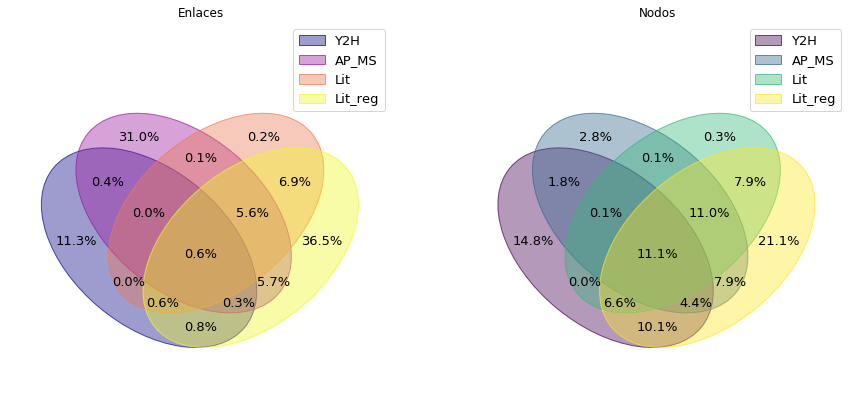

In [44]:
from venn import venn
f, axs = plt.subplots(1, 2 , figsize=(15,15))
venn_e = venn(enlaces, fmt="{percentage:.1f}%", ax= axs[0], cmap = "plasma")
axs[0].set_title("Enlaces")
venn(nodos, fmt="{percentage:.1f}%", ax= axs[1] )
axs[1].set_title("Nodos")
#Guarda toda la imagen
plt.savefig(f'tabla_2.png')
# Por separado
extent = axs[0].get_window_extent().transformed(f.dpi_scale_trans.inverted())
f.savefig('enlaces_tabla2', bbox_inches=extent, dpi = 200)
extent = axs[1].get_window_extent().transformed(f.dpi_scale_trans.inverted())
f.savefig('nodos_tabla2', bbox_inches=extent, dpi = 200)

plt.show()

# Figura 1

In [10]:
lista_esenciales = abrir_txt('./data/Essential_ORFs_paperHe.txt')

grados_ordenados = {}

def segundo_lugar(item):
    return item[1]

for red in redes_dict.keys():
    grados_lista = list(redes_dict[red]['Grafo'].degree())
    grados_lista.sort(key = segundo_lugar, reverse = True)
    grados_ordenados[red] = grados_lista

In [197]:
from operator import itemgetter

umbral = {}

def calcular_esenciales(red):
    
    nodos = list(map(itemgetter(0), grados_ordenados[red])) #lista de nodos ordenados por grado
    orden_grados = list(map(itemgetter(1), grados_ordenados[red])) #grados de dichos nodos
    
    hub_definition = []
    fraccion_hubs_esenciales = []
    umbral_list = []

    for i in orden_grados: 
        lista_nodos = []
        for j in range(0,len(nodos)):
            if orden_grados[j] >= i: 
                lista_nodos.append(nodos[j]) #solo si tienen mayor grado
        
        hub_definition.append(len(lista_nodos) / redes_dict[red]['Nodos']) #propocion de nodos que tomo como hub
        hubs_esenciales = set(lista_nodos).intersection(lista_esenciales) #nodos esenciales dentro de los hubs
        fracc_hubs_esen = len(hubs_esenciales) / len(lista_nodos) 
        fraccion_hubs_esenciales.append(fracc_hubs_esen) #fraccion entre los hubs de esenciales   
        if fracc_hubs_esen *100 > 20: 
            umbral_list.append(i)
    
    umbral[red] = max(umbral_list)
    return hub_definition, fraccion_hubs_esenciales

In [198]:
nodos_esenciales_frac = {}
for red in redes_dict.keys():
    nodos_esenciales_frac[red] = len(set(redes_dict[red]["Grafo"].nodes()).intersection(lista_esenciales)) / redes_dict[red]['Nodos'] * 100

nodos_esenciales_frac

{'Y2H': 22.348860257680872,
 'AP_MS': 37.42293464858199,
 'Lit': 40.69010416666667,
 'Lit_reg': 27.094042939219836}

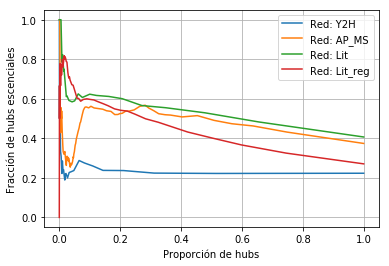

In [199]:
correlaciones = {}
umbral = {}
for red in redes_dict.keys():
    x, y = calcular_esenciales(red)
    correlaciones[red] = {}
    correlaciones[red]['Kendall'] = scipy.kendalltau(x,y)[0]
    correlaciones[red]['Kendall p value'] = (scipy.kendalltau(x,y)[1])
    correlaciones[red]['Spearman'] = scipy.spearmanr(x,y)[0]
    correlaciones[red]['Spearman p value'] = scipy.spearmanr(x,y)[1]
    plt.plot(x, y, label = f'Red: {red}')
    plt.xlabel('Proporción de hubs')
    plt.ylabel('Fracción de hubs escenciales')
    plt.legend()
    

plt.grid()
plt.savefig('fig_1.png', dpi = 200)
plt.show()

In [200]:
umbral

{'Y2H': 91, 'AP_MS': 127, 'Lit': 40, 'Lit_reg': 248}

In [16]:
correlaciones_df = correlaciones.copy() #no modificar data
df = pd.DataFrame(correlaciones_df).transpose()
df = df.astype(float).round(3)
df

,Kendall,Kendall p value,Spearman,Spearman p value
Y2H,-0.351,0.0,-0.448,0.0
AP_MS,-0.689,0.0,-0.693,0.0
Lit,-0.971,0.0,-0.994,0.0
Lit_reg,-0.995,0.0,-0.998,0.0


# Figura 3

Esto es igualito al ejercicio 2c del TPC_01.
Tenemos que considerar 7 centralidades:
* Remover nodos esenciales de una
* Random (ver código ya hecho)
* Eigenvalue: diccionario_centralidad_autovalor = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
* Degree centrality diccionario_centralidad_grado = nx.degree_centrality(Red)
* Shortest path diccionario_centralidad_intermediatez = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
* current_flow 
* diccionario_centralidad_cercania = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)
*

In [7]:
cantidad_de_nodos = {}
for red in redes_dict.keys():
    cantidad_de_nodos[red] = redes_dict[red]['Nodos']

### 1) Esenciales

In [8]:
def sacar_esenciales(red, lista_esenciales):
    Graph = redes_dict[red]['Grafo'].copy() #no modifico originales
    Graph.remove_nodes_from(lista_esenciales)
    fracc_nodos_sacados = 1 - Graph.number_of_nodes() / cantidad_de_nodos[red]
      
    
    componentes=[Graph.subgraph(componente)
                 for componente in sorted(nx.connected_components(Graph),
                                          key=len, reverse=True)]
    gigante = componentes[0]
    fracc_tamamo_gigante = gigante.number_of_nodes() / cantidad_de_nodos[red]
    return fracc_nodos_sacados, fracc_tamamo_gigante

Esto sólo para saber

Ploteo para ir viendo, pero después hacemos toda una figura

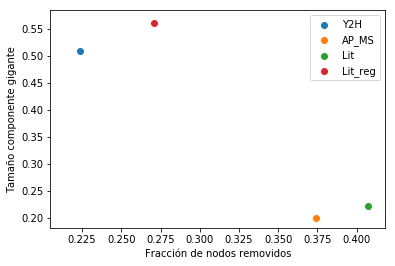

In [11]:
x_esen = {}
y_esen = {}

for red in redes_dict.keys():
    x_esen[red], y_esen[red] = sacar_esenciales(red, lista_esenciales)
    plt.scatter(x_esen[red], y_esen[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()


### 2) Random

In [20]:
def desarme_random(red):
    tamano_gigante = np.array([])
    Red_rota_rand = redes_dict[red]['Grafo'].copy()
    nodes = list(Red_rota_rand.nodes)
    random.shuffle(nodes)
    
    for node in nodes:
        Red_rota_rand.remove_node(node)
        componentes  = sorted(nx.connected_components(Red_rota_rand), 
                                                   key=len, reverse=True)
        
                        
        if len(componentes) >= 1:
            gigante = Red_rota_rand.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cantidad_de_nodos[red] )
            
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cantidad_de_nodos[red] - tamano ), 'constant')

    return tamano_gigante

In [24]:
import time
from tqdm import *

iteraciones_random = 10
i = 0
y_rand = {k: np.zeros(shape = redes_dict[k]["Nodos"]) for k in redes_dict.keys()}

while i < iteraciones_random:
    for red in redes_dict.keys():
        start = time.time()
        y_rand[red] = y_rand[red] + desarme_random(red)
        end = time.time()
        print(f'La red {red}_{i} tardó {round(end - start, 2)}s')
    i += 1

La red Y2H_0 tardó 3.98s
La red AP_MS_0 tardó 2.97s
La red Lit_0 tardó 2.33s
La red Lit_reg_0 tardó 12.67s
La red Y2H_1 tardó 3.9s
La red AP_MS_1 tardó 2.74s
La red Lit_1 tardó 2.21s
La red Lit_reg_1 tardó 11.94s
La red Y2H_2 tardó 3.89s
La red AP_MS_2 tardó 2.83s
La red Lit_2 tardó 2.19s
La red Lit_reg_2 tardó 14.86s
La red Y2H_3 tardó 4.12s
La red AP_MS_3 tardó 2.8s
La red Lit_3 tardó 2.18s
La red Lit_reg_3 tardó 12.03s
La red Y2H_4 tardó 3.87s
La red AP_MS_4 tardó 2.74s
La red Lit_4 tardó 2.23s
La red Lit_reg_4 tardó 11.86s
La red Y2H_5 tardó 3.89s
La red AP_MS_5 tardó 2.79s
La red Lit_5 tardó 2.18s
La red Lit_reg_5 tardó 11.94s
La red Y2H_6 tardó 3.93s
La red AP_MS_6 tardó 2.75s
La red Lit_6 tardó 2.2s
La red Lit_reg_6 tardó 12.24s
La red Y2H_7 tardó 3.9s
La red AP_MS_7 tardó 2.76s
La red Lit_7 tardó 2.2s
La red Lit_reg_7 tardó 12.4s
La red Y2H_8 tardó 3.91s
La red AP_MS_8 tardó 2.8s
La red Lit_8 tardó 2.24s
La red Lit_reg_8 tardó 12.19s
La red Y2H_9 tardó 3.83s
La red AP_MS_9 tard

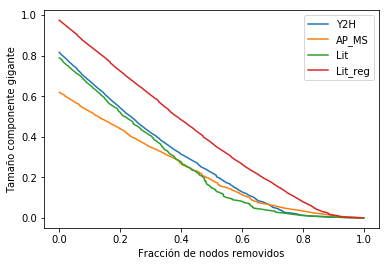

In [25]:
x_rand_plot = {}
y_rand_plot = {}

for red in y_rand.keys():
    y_rand_plot[red] = y_rand[red] / iteraciones_random
    x_rand_plot[red] = [x /  cantidad_de_nodos[red] for x in range(0, len(y_rand[red]))]
    plt.plot(x_rand_plot[red],y_rand_plot[red], label = f'{red}')
    
plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 3) Eigenvalue

In [31]:
import operator

def desarme_eigenvalue(red):
    centrality = nx.eigenvector_centrality(redes_dict[red]["Grafo"], max_iter=1000, tol=1e-03)

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > 1:
        node = max(centrality.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
        
        #print(Red_rota.number_of_nodes())
        centrality = nx.eigenvector_centrality(Red_rota, max_iter=1000, tol=1e-03)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cantidad_de_nodos[red] )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cantidad_de_nodos[red] - tamano ), 'constant')

    return tamano_gigante

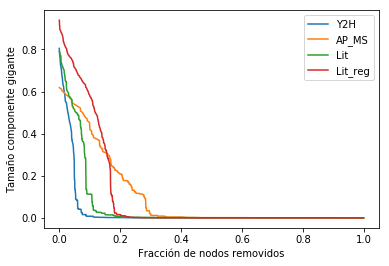

In [32]:
x_eigen = {}
y_eigen = {}

for red in redes_dict.keys():
    y_eigen[red] = desarme_eigenvalue(red)
    x_eigen[red] = [x / cantidad_de_nodos[red] for x in range(0, len(y_eigen[red]))]
    plt.plot(x_eigen[red], y_eigen[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 4) Degree

In [33]:
import operator

def desarme_degree(red):
    degree = nx.degree_centrality(redes_dict[red]["Grafo"])

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > 1:
        node = max(degree.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
        
        #print(Red_rota.number_of_nodes())
        degree = nx.degree_centrality(Red_rota)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cantidad_de_nodos[red] )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cantidad_de_nodos[red] - tamano ), 'constant')

    return tamano_gigante

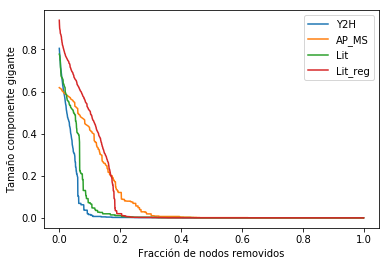

In [34]:
x_deg = {}
y_deg = {}

for red in redes_dict.keys():
    y_deg[red] = desarme_degree(red)
    x_deg[red] = [x / cantidad_de_nodos[red] for x in range(0, len(y_deg[red]))]
    plt.plot(x_deg[red], y_deg[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 5) Betweeness

In [35]:
import operator

def desarme_bet(red):
    k = 20
    bet = nx.betweenness_centrality(redes_dict[red]["Grafo"], k = k)

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > k:
        node = max(bet.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
       
        bet = nx.betweenness_centrality(Red_rota, k = k)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cantidad_de_nodos[red] )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cantidad_de_nodos[red] - tamano ), 'constant')

    return tamano_gigante

La red Y2H tardó 24.45s
La red AP_MS tardó 14.21s
La red Lit tardó 11.56s
La red Lit_reg tardó 110.05s


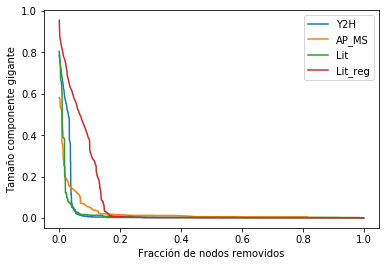

In [36]:
x_bet = {}
y_bet = {}

for red in redes_dict.keys():
    start = time.time()
    y_bet[red] = desarme_bet(red)
    end = time.time()
    print(f'La red {red} tardó {round(end - start, 2)}s')
    x_bet[red] = [x / cantidad_de_nodos[red] for x in range(0, len(y_bet[red]))]
    plt.plot(x_bet[red], y_bet[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 6) Closeness

In [37]:
import igraph as ig

def close_ig(red):
    G_ig = ig.Graph(directed=True)
    G_ig.add_vertices(list(red.nodes()))
    G_ig.add_edges(list(red.edges()))
    conectado = G_ig.components()[0]
    component = G_ig.subgraph(conectado)
    closeness = component.closeness(vertices=None, mode='ALL', cutoff=None, weights=None, normalized=True)
    keys = list(red.nodes())
    close_dict = dict(zip(keys, closeness))
    return close_dict



In [38]:
import operator

def desarme_close(red):
    grafo = redes_dict[red]['Grafo'].copy()
    close = close_ig(grafo)
       
    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()
    
    i = 0
    size_gigante = cantidad_de_nodos[red]
    
    while 1 <  Red_rota.number_of_nodes():
        node = max(close.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)

        close = close_ig(Red_rota)
        componentes = sorted(nx.connected_components(Red_rota), key=len, reverse=True)
        i += 1                                                   
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0])
            size_gigante = gigante.number_of_nodes()
            tamano_gigante = np.append(tamano_gigante, size_gigante / cantidad_de_nodos[red] )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cantidad_de_nodos[red] - tamano ), 'constant')

    return tamano_gigante 
     

La red Y2H tardó 7.06s
La red AP_MS tardó 6.0s
La red Lit tardó 4.17s
La red Lit_reg tardó 26.96s


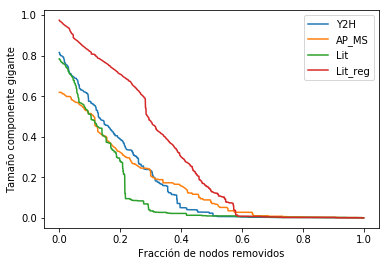

In [39]:
x_clos = {}
y_clos = {}

for red in redes_dict.keys():
    start = time.time()
    y_clos[red] = desarme_close(red)
    end = time.time()
    print(f'La red {red} tardó {round(end - start, 2)}s')
    x_clos[red] = [xs / cantidad_de_nodos[red] for xs in range(0, len(y_clos[red]))]
    plt.plot(x_clos[red], y_clos[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

# En un plot para cada una

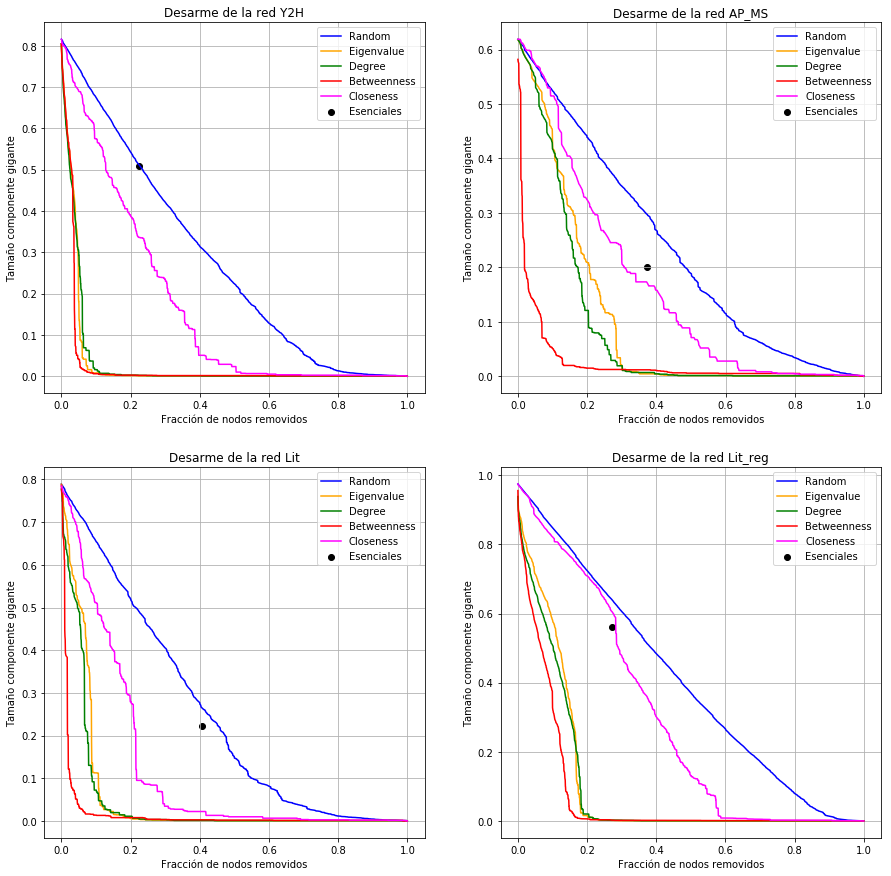

In [40]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()
lista = ["Lit_reg"]

for i,red in enumerate(redes_dict.keys()):
#esen
    ax[i].scatter(x_esen[red], y_esen[red], label = 'Esenciales', c = "black")

#rand    
    ax[i].plot(x_rand_plot[red], y_rand_plot[red], label = 'Random', c = "blue")
    
#eigen
    ax[i].plot(x_eigen[red], y_eigen[red], label = 'Eigenvalue', c = "orange")

#degree
    ax[i].plot(x_deg[red], y_deg[red], label = 'Degree', c = "green")

#Betweenness
    ax[i].plot(x_bet[red], y_bet[red], label = 'Betweenness', c = 'red')

#Closeness
    ax[i].plot(x_clos[red], y_clos[red], label = 'Closeness', c = 'magenta')

    ax[i].legend()
    ax[i].set_title(f'Desarme de la red {red}')
    ax[i].set_xlabel("Fracción de nodos removidos")
    ax[i].set_ylabel("Tamaño componente gigante")
    ax[i].grid()
plt.savefig(f'fig_3.png')
plt.show()

## Tabla 3

In [63]:
esenciales_grado = {}
for red in redes_dict.keys():
    grafo = redes_dict[red]["Grafo"]
    esenciales_en_red = set(grafo.nodes()).intersection(lista_esenciales)
    esenciales_grado[red] = {}
    for node in esenciales_en_red:
        esenciales_grado[red][node] = nx.degree(grafo, node)

In [64]:
def simil_esenciales(red):

    nodos_a_sacar = []
    nodos_equivalente = []
    nodos_sin_equivalente = []

    nodos_esenciales = esenciales_grado[red]
    grafo = redes_dict[red]["Grafo"]
    d = dict(grafo.degree())
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)


    for node, degree in nodos_esenciales.items():
        for (u,v) in d.items():
            if degree == v and not u in nodos_a_sacar and not u in nodos_esenciales.keys():
                nodos_a_sacar.append(u)
                nodos_equivalente.append(node)
                break

    faltan = set(nodos_esenciales.keys()).difference(set(nodos_equivalente))
    for nodo in faltan:
        nodos_sin_equivalente.append(nodo)

    return nodos_a_sacar + nodos_sin_equivalente

In [65]:
def random_same_degree(red):
    nodos_a_sacar = []

    nodos_esenciales = esenciales_grado[red]
    grafo = redes_dict[red]["Grafo"]
    d = dict(grafo.degree())
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)


    for node, degree in nodos_esenciales.items():
        for (u,v) in d.items():
            if degree == v and not u in nodos_a_sacar:
                nodos_a_sacar.append(u)
                break
                
    return nodos_a_sacar

In [66]:
cg_rand= {k: [] for k in redes_dict.keys()}
cg_simil = {k: [] for k in redes_dict.keys()}

times = 100
i = 0

while i < times:
    for red in redes_dict.keys():
        nodos_a_sacar_simil = simil_esenciales(red)
        _ , tamano_cg_simil = sacar_esenciales(red, nodos_a_sacar_simil)
        cg_simil[red].append(tamano_cg_simil)
        
        nodos_a_sacar_rand = random_same_degree(red)
        _ , tamano_cg_rand = sacar_esenciales(red, nodos_a_sacar_rand)
        cg_rand[red].append(tamano_cg_rand)
        
    i += 1



In [84]:
x_esen = {}
y_esen = {}

y_simil = {}
simil_error = {}
simil_otro_error = {}
y_rand = {}
rand_error = {}
rand_otro_error = {}

for red in redes_dict.keys():
    y_simil[red] = np.array(cg_simil[red]).mean()
    simil_error[red] = np.array(cg_simil[red]).std()
    simil_otro_error[red] = max(cg_simil[red]) - min(cg_simil[red])
    
    y_rand[red] = np.array(cg_rand[red]).mean()
    rand_error[red] = np.array(cg_rand[red]).std()
    rand_otro_error[red] = max(cg_rand[red]) - min(cg_rand[red])
      
    grafo = redes_dict[red]["Grafo"]
    esenciales_en_red = set(grafo.nodes()).intersection(lista_esenciales)
    x_esen[red], y_esen[red] = sacar_esenciales(red, esenciales_en_red)

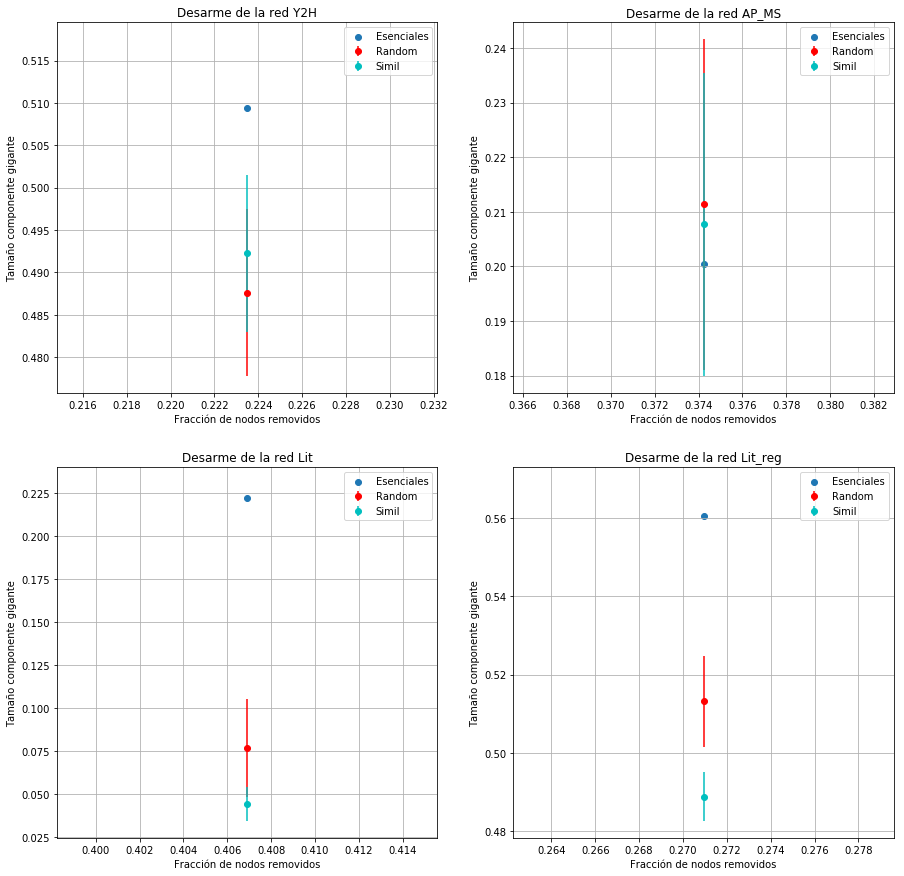

In [89]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()

for i,red in enumerate(redes_dict.keys()):
#esen
    ax[i].scatter(x_esen[red], y_esen[red], label = 'Esenciales')

#rand
    ax[i].errorbar(x_esen[red], y_rand[red], yerr = rand_error[red], fmt = 'ro', label = 'Random')
    
    ax[i].errorbar(x_esen[red], y_simil[red], yerr = simil_error[red], fmt = 'co', label = 'Simil')


    ax[i].legend()
    ax[i].set_title(f'Desarme de la red {red}')
    ax[i].set_xlabel("Fracción de nodos removidos")
    ax[i].set_ylabel("Tamaño componente gigante")
    ax[i].grid()
plt.savefig(f'tabla_3.png')
plt.show()

Tomé error como dif entre max y min (mas que error es rango)

In [86]:
df = pd.DataFrame([y_esen, y_rand, rand_otro_error, y_simil, simil_otro_error], index=['Esenciales', 'Random', 'Error', 'Simil', 'Error']).transpose()
df.round(3)

,Esenciales,Random,Error,Simil,Error
AP_MS,0.200,0.211,0.151,0.208,0.117
Lit,0.222,0.077,0.128,0.044,0.040
Lit_reg,0.561,0.513,0.054,0.489,0.030
Y2H,0.509,0.488,0.049,0.492,0.052


Veamos la otra figura 2b. Primero veo cuantos esenciales hay por grado y cuantos nodos hay por grado.

In [47]:
def cantidad_por_grado(dictionary, new_dict):
    for pair in dictionary.items():
        if pair[1] not in new_dict.keys():
            new_dict[pair[1]] = 0
        new_dict[pair[1]] += 1   

esenciales_por_grado = {}
nodos_por_grado = {}

for red in redes_dict.keys():
    esenciales_por_grado[red] = {}
    new_dict = esenciales_por_grado[red]
    cantidad_por_grado(esenciales_grado[red], new_dict)
    
    grados = dict(redes_dict[red]['Grafo'].degree())
    nodos_por_grado[red] = {}
    new_dict = nodos_por_grado[red]
    cantidad_por_grado(grados, new_dict)

In [152]:
probabilidad_esencial = {}
for red in redes_dict.keys():
    probabilidad_esencial[red] = {}
    for grado in nodos_por_grado[red].keys():
        esencial = esenciales_por_grado[red].get(grado)
        if esencial:
            probabilidad_esencial[red][grado] =  esencial / nodos_por_grado[red][grado]

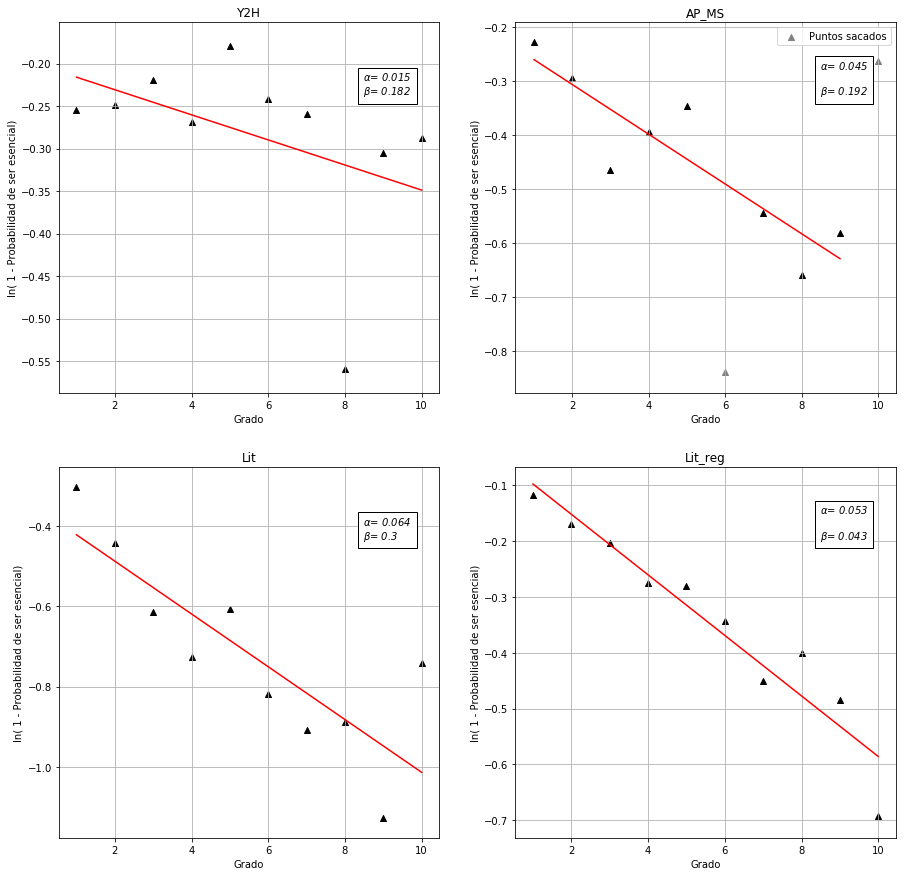

In [296]:
alfa_dict = {}
beta_dict = {}

your_keys = list(range(1,11))
ap_keys = list(range(1,6)) + list(range(7, 10))

f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()

for i,red in enumerate(redes_dict.keys()):
    if red == "AP_MS":
        dict_you_want = {your_key: probabilidad_esencial[red][your_key] for your_key in ap_keys}
        sacados = {6: probabilidad_esencial[red][6], 10: probabilidad_esencial[red][10]}
        x_sacados = list(sacados.keys())
        pe_sacados = list(sacados.values())
        y_sacados = [np.log(1 - pe) for pe in pe_sacados]
        ax[i].scatter(x_sacados, y_sacados, marker = "^", color = 'grey', label = "Puntos sacados")
        ax[i].legend()
    else:
        dict_you_want = {your_key: probabilidad_esencial[red][your_key] for your_key in your_keys}
    
    x = list(dict_you_want.keys())
    pe = list(dict_you_want.values())
    y = [np.log(1 - pe) for pe in pe]
    ax[i].scatter(x, y, marker = "^", color = 'black') 
         
    ajuste, cov = np.polyfit(x, y, 1, cov = True)
    error = np.sqrt(cov[1][1])
    lineal = np.poly1d(ajuste)
    ax[i].plot(x, lineal(x), color = "red")
    alfa_dict[red] = 1 - np.exp(lineal[1])
    beta_dict[red] = 1 - np.exp(lineal[0])
    t = (r"$\alpha$" f"= {round(1 - np.exp(lineal[1]), 3)} \n" r" $\beta$" f"= {round(1 - np.exp(lineal[0]), 3)}")
    ax[i].text(0.8, 0.8, t , style='italic', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5}, transform=ax[i].transAxes, wrap = True )
    
    
    
    ax[i].set_title(f'{red}')
    #ax[i].legend()
    ax[i].set_xlabel("Grado")
    ax[i].set_ylabel("ln( 1 - Probabilidad de ser esencial)")
    ax[i].grid()

plt.savefig("2b.png")
plt.show()


# Con Y2H no es posible este método. Hay que ver si hice bien las cuentas de alpha y beta. Para Ap es falopa. Saqué el grado 6 y 10 porque daban raros. 

# Tabla 5

Observados en las redes

In [361]:
def pares_mismo_tipo(grafo, nodos_esenciales):
    nodos_esen = list(set(grafo.nodes()).intersection(nodos_esenciales)) #esenciales en la red
    nodos_no_esen = list(set(grafo.nodes()).difference(nodos_esenciales)) #no esenciales en la red
    pares = 0
    i = 0
    while i < len(nodos_esen):
        for j in range(i + 1, len(nodos_esen)):
            if cantidad_vecinos_comunes(grafo, nodos_esen[i], nodos_esen[j]) >= 3 and not son_vecinos(grafo, nodos_esen[i], nodos_esen[j]):
                pares += 1
        i += 1
    
    i = 0
    while i < len(nodos_no_esen):
        for j in range(i + 1, len(nodos_no_esen)):
            if cantidad_vecinos_comunes(grafo, nodos_no_esen[i], nodos_no_esen[j]) >= 3 and not son_vecinos(grafo, nodos_no_esen[i], nodos_no_esen[j]):
                pares += 1
        
        i += 1
    
    return pares
                
def cantidad_vecinos_comunes(grafo, nodo_1, nodo_2):
    return len(list(nx.common_neighbors(grafo, nodo_1,nodo_2)))
            
def son_vecinos(grafo, nodo_1, nodo_2):
    return nodo_2 in list(grafo.neighbors(nodo_1))

In [362]:
pares = {}
for red in redes_dict.keys():
    pares[red] = pares_mismo_tipo(redes_dict[red]['Grafo'], lista_esenciales)  

In [363]:
pares

{'Y2H': 352, 'AP_MS': 5907, 'Lit': 389, 'Lit_reg': 6187}

Modelos nulos en base al line fitting

In [364]:
def null_model_PE(red,alpha,beta):
    G = red.copy() #no modifico originales
    esenciales_list = [] 
    for node in G.nodes():
        k = G.degree[node]
        PE = 1- (1-beta) * ((1-alpha)**k) #Probabilidad de que sea esencial
        random_sample = random.random()
        if random_sample <= PE:
            esenciales_list.append(node) # Agrego el nodo al listado de esenciales
    esenciales_list = set(esenciales_list) # Saco duplicados
    return esenciales_list

def null_model_alpha_beta(red, alpha, beta):
    esenciales_lista = []
    G = red.copy() #no modifico originales
    for node in G.nodes():
        random_sample = random.random()
        if random_sample <= beta:
            esenciales_lista.append(node)
    
    for edge in G.edges(): 
        random_sample = random.random()
        if random_sample <= alpha: 
            esenciales_lista.append(edge[0])
            esenciales_lista.append(edge[1])
    esenciales_lista = set(esenciales_lista) # Saco duplicados
    return esenciales_lista

# perdon por los prints pero tarda años. Hay que averiguar qué carajo la AP MS

In [368]:
pares_random_alfa_beta = {}
pares_random_pe = {}

for red in redes_dict.keys():
    lista_alfa_beta = []
    lista_pe = []
    grafo = redes_dict[red]["Grafo"]
    pares_random_alfa_beta[red] = []
    pares_random_pe[red] = []
    alfa = alfa_dict[red]
    beta = beta_dict[red]
    i = 0
    while i < 20:
        esen_a_b = null_model_alpha_beta(grafo, alfa, beta)
        lista_alfa_beta.append(pares_mismo_tipo(grafo, esen_a_b))
        esen_pe = null_model_PE(grafo, alfa, beta)
        lista_pe.append(pares_mismo_tipo(grafo, esen_pe))
        print("vivo")
        i += 1
    pares_random_alfa_beta[red] = np.array(lista_alfa_beta).mean()
    pares_random_pe[red] = np.array(lista_pe).mean()

vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo
vivo


In [369]:
pares_random_alfa_beta

{'Y2H': 293.15, 'AP_MS': 7484.85, 'Lit': 377.75, 'Lit_reg': 5682.75}

In [370]:
pares_random_pe

{'Y2H': 289.7, 'AP_MS': 7326.75, 'Lit': 384.9, 'Lit_reg': 5778.9}